# Demo for a model for wind power production

This notebook shows the process I went through for building a model to predict wind production given the wind data from several stations.

### Housekeeping

To install the needed packages to run the notebook use:

```
conda install -c conda-forge xarray jupyterlab matplotlib pynio scikit-learn dask
conda install sklearn
pip3 install --user windpowerlib pygam
```

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

pd.set_option('display.max_rows', 10)

### Read in the CSV data

The first step is to read in the data, plot it and get a feel for it. I then added in `assert` statements to make sure everything is read in correctly.

In [2]:
df = pd.read_csv("WindData.csv", sep=";", decimal=",", parse_dates=["Date"], dayfirst=True).set_index("Date") # dayfirst very important!

assert df.index.is_monotonic, "Parsing the dates failed; they are out of order."
assert not df.isna().any(axis=None), 'NaN somewhere in the data'

df

,Wind Production DK1,Wind Production DK2,Station1_WND,Station1_DD,Station2_WND,Station2_DD,Station3_WND,Station3_DD,Station4_WND,Station4_DD,...,Station8_WND,Station8_DD,Station9_WND,Station9_DD,Station10_WND,Station10_DD,Station11_WND,Station11_DD,Station12_WND,Station12_DD
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1396.847852,122.705532,9.6,191,6.1,179.0,7.0,224.0,8.4,198.0,...,12.4,199.0,7.7,228,6.1,195,5.7,184,10.2,202
2016-01-01 01:00:00,1304.469541,105.147667,9.8,188,6.1,177.0,6.6,227.0,8.3,192.0,...,13.2,197.0,7.3,231,6.0,193,5.3,185,10.7,200
2016-01-01 02:00:00,1201.416846,80.806082,9.9,188,6.6,174.0,6.3,231.0,8.3,183.0,...,13.4,197.0,6.9,235,6.3,193,5.3,188,10.4,199
2016-01-01 03:00:00,1198.324268,67.637683,10.0,187,7.1,172.0,6.0,234.0,8.4,173.0,...,13.6,197.0,6.6,239,6.7,193,5.2,191,10.1,197
2016-01-01 04:00:00,1113.926804,51.576228,9.8,188,7.5,172.0,6.1,232.0,8.5,171.0,...,13.0,202.0,6.4,237,7.0,193,4.8,195,9.7,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,3049.623720,843.204789,12.7,250,12.5,249.0,13.1,244.0,12.9,248.0,...,14.5,255.0,14.2,239,12.1,251,10.9,254,11.0,244
2016-12-31 20:00:00,3045.754898,848.660820,12.7,250,12.2,248.0,13.0,244.0,12.7,247.0,...,14.8,253.0,14.1,240,12.0,250,10.9,253,11.4,245
2016-12-31 21:00:00,3091.585559,845.486402,12.8,249,12.0,247.0,13.0,244.0,12.6,246.0,...,15.2,252.0,14.1,241,11.9,248,11.0,252,11.8,246


### Split the data into the different types: wind speed, wind direction, power production

In [3]:

#Variable names follow column names
WNDs = df[[col for col in df.columns if "_WND" in col]] # select columns
WNDs = WNDs.rename(columns={col:col[:-4] for col in WNDs.columns}) #strip suffix, just Station*

DDs = df[[col for col in df.columns if "_DD" in col]] # select columns
DDs = DDs.rename(columns={col:col[:-3] for col in DDs.columns}) #strip suffix, just Station*

PROD = df[[col for col in df.columns if "Production" in col]] # select columns

#Make sure the data makes sense:
assert WNDs.min().min() >= 0, 'speeds are always > 0'
assert (DDs.min().min() >= 0) and (DDs.max().max() <= 360), 'angles must be between (0,360)'

assert all(WNDs.columns == DDs.columns), 'The two arrays should have the same column names.'

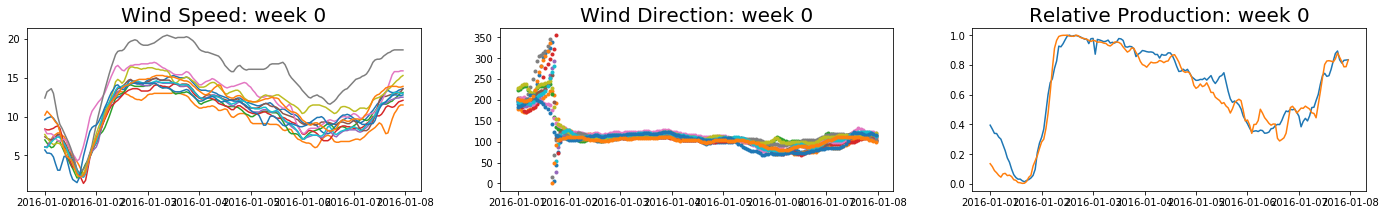

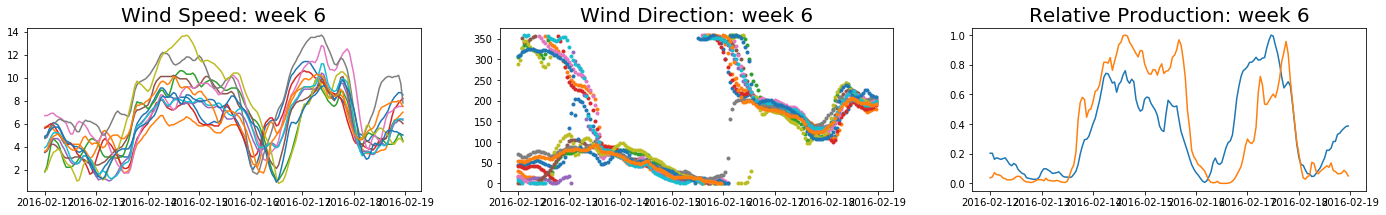

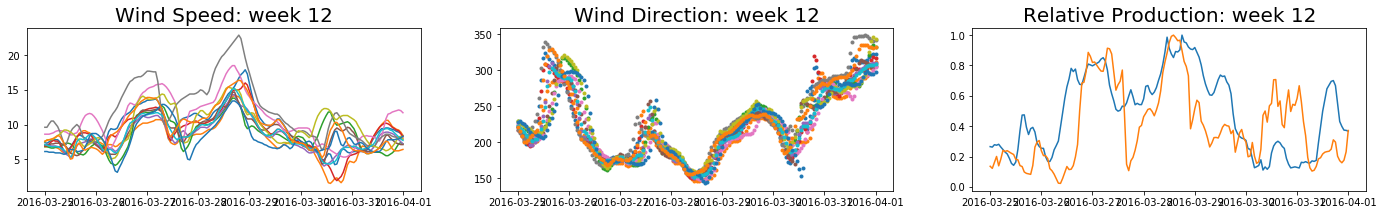

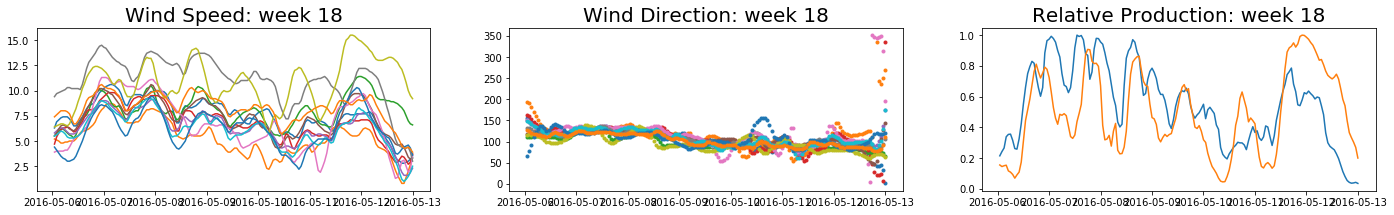

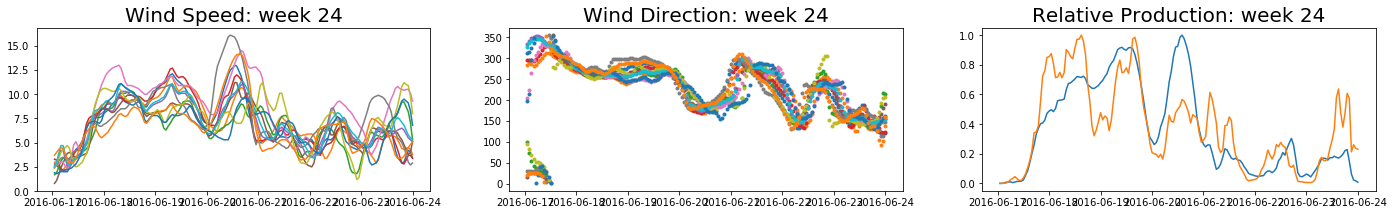

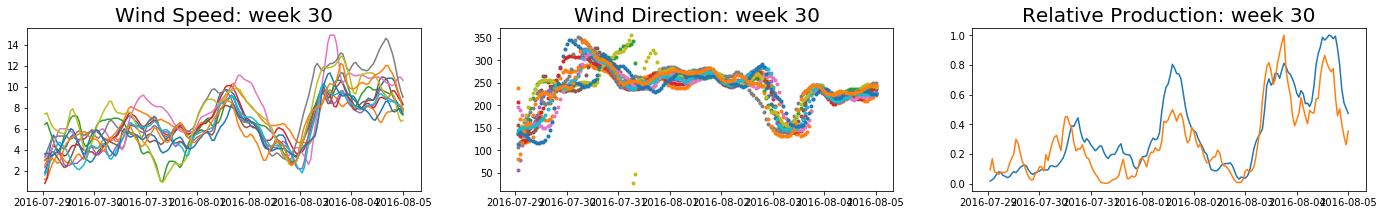

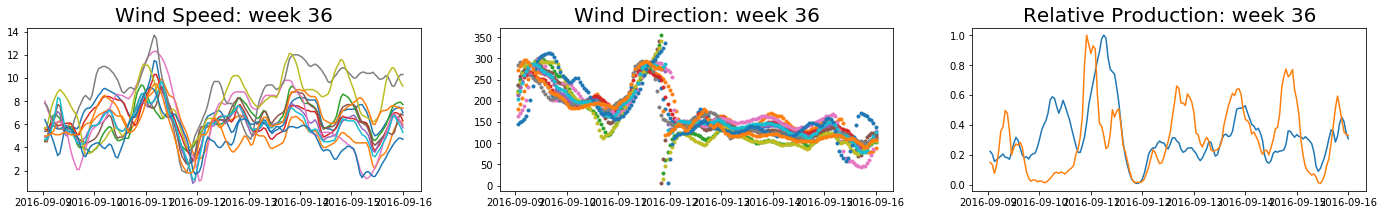

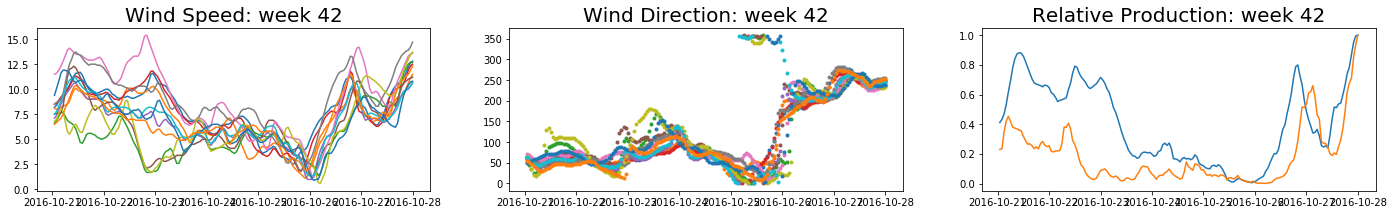

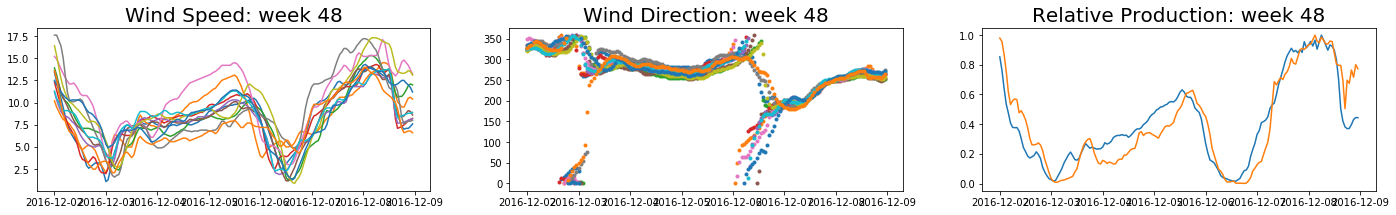

In [4]:
#after plotting a few weeks, decided to make a function
def plot_week(week):
    t_s = 24 * 7 * week
    t_e = t_s + 24 * 7
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,3))

    ax0.plot(WNDs[t_s:t_e])
    ax0.set_title(f'Wind Speed: week {week}', fontsize=20)

    ax1.plot(DDs[t_s:t_e],'.')
    ax1.set_title(f'Wind Direction: week {week}', fontsize=20)

    rel_prod0, rel_prod1 = PROD.iloc[t_s:t_e,0], PROD.iloc[t_s:t_e,1]
    rel_prod0, rel_prod1 = rel_prod0 / np.max(rel_prod0), rel_prod1 / np.max(rel_prod1)
    
    ax2.plot(rel_prod0.index, rel_prod0, rel_prod1.index, rel_prod1)
    ax2.set_title(f'Relative Production: week {week}', fontsize=20)
    
for week in range(0,52,6):
    plot_week(week)

### Thoughts on charts

- Just plot points for Wind Direction graphs to prevent vertical lines wrapping around from 0 to 360.
- Generally a lot of correlation between speeds and between directions.
- Week like 18 and 36 and see that there is more variability in production over time when the speeds are not as correlated.

### Idea: Additive mixture model

Intuition would say that the wind production in the two markets could be split up into the areas around the 12 stations we have wind data for. So if we could model the contribution from each station, then we would just add everything together to get the total. This is a type of a mixture model, where the output is a mixture of several input models.

A refinement of that comes from knowledge about wind turbines and farms. The turbines are oriented in specific direction and some of them cannot adjust to the prevailing wind direction and at the farm level, the layout of the wind turbines is better for certain directions. Therefore, I will setup not just 1 model per station, but one per station and per compass direction.

For example: 8 * 12 = 96 inputs

#### Now generate those features

In [7]:
#Leave in code, so we can explore 
number_of_angles = 2 #Note we only have to go from 0-180, if wind is +5 at 90deg, then it is -5 at 270deg.


wind_u = WNDs * np.sin(np.deg2rad(DDs))
wind_v = WNDs * np.cos(np.deg2rad(DDs))

#convert to multi-dimensional xarray
wind_u = xr.DataArray(wind_u, dims=["Date","Station"])
wind_v = xr.DataArray(wind_v, dims=["Date","Station"])

#set out the angles
angles = np.arange(0,180,180/number_of_angles)
angles = xr.DataArray(angles, dims=["Angle"], coords={"Angle": angles})

#We have 3 dimensions, Date, Station, and Angle, xarray keeps track of that for us.
features_da = np.sin(np.deg2rad(angles)) * wind_u + np.cos(np.deg2rad(angles)) * wind_v #this line is fun!
features_ws = features_da.stack(projection=["Station","Angle"]).to_pandas()

features_ws

Station              Station1             Station2             Station3  \
Angle                    0.0        90.0      0.0        90.0      0.0    
Date                                                                      
2016-01-01 00:00:00 -9.423621  -1.831766 -6.099071   0.106460 -5.035379   
2016-01-01 01:00:00 -9.704627  -1.363896 -6.091640   0.319249 -4.501189   
2016-01-01 02:00:00 -9.803654  -1.377814 -6.563845   0.689888 -3.964718   
2016-01-01 03:00:00 -9.925462  -1.218693 -7.030903   0.988129 -3.526712   
2016-01-01 04:00:00 -9.704627  -1.363896 -7.427011   1.043798 -3.755535   
...                       ...        ...       ...        ...       ...   
2016-12-31 19:00:00 -4.343656 -11.934096 -4.479599 -11.669755 -5.742662   
2016-12-31 20:00:00 -4.343656 -11.934096 -4.570200 -11.311643 -5.698825   
2016-12-31 21:00:00 -4.587110 -11.949829 -4.688774 -11.046058 -5.698825   
2016-12-31 22:00:00 -4.551273 -11.856471 -4.307976 -10.662614 -5.494037   
2016-12-31 23:00:00 -4.682582 -11.589798 -3.762222 -10.336619 -5.451776   

Station                         Station4             Station5             \
Angle                     90.0      0.0        90.0      0.0        90.0   
Date                                                                       
2016-01-01 00:00:00  -4.862609 -7.988875  -2.595743 -5.833459  -1.783467   
2016-01-01 01:00:00  -4.826934 -8.118625  -1.725667 -5.943657  -1.372201   
2016-01-01 02:00:00  -4.896020 -8.288625  -0.434388 -6.518743  -1.032467   
2016-01-01 03:00:00  -4.854102 -8.337388   1.023702 -6.973363  -0.610090   
2016-01-01 04:00:00  -4.806866 -8.395351   1.329693 -7.272221  -0.636237   
...                        ...       ...        ...       ...        ...   
2016-12-31 19:00:00 -11.774202 -4.832425 -11.960672 -4.493408 -10.585806   
2016-12-31 20:00:00 -11.684323 -4.962285 -11.690412 -4.636798 -10.414418   
2016-12-31 21:00:00 -11.684323 -5.124882 -11.510673 -4.817848 -10.331909   
2016-12-31 22:00:00 -11.782001 -4.845066 -11.414260 -4.775586 -10.241278   
2016-12-31 23:00:00 -11.691370 -4.766920 -11.230159 -4.775586 -10.241278   

Station                ...       Station8             Station9             \
Angle                  ...           0.0        90.0      0.0        90.0   
Date                   ...                                                  
2016-01-01 00:00:00    ...     -11.724430  -4.037045 -5.152306  -5.722215   
2016-01-01 01:00:00    ...     -12.623223  -3.859307 -4.594039  -5.673166   
2016-01-01 02:00:00    ...     -12.814484  -3.917781 -3.957677  -5.652149   
2016-01-01 03:00:00    ...     -13.005745  -3.976255 -3.399251  -5.657304   
2016-01-01 04:00:00    ...     -12.053390  -4.869886 -3.485690  -5.367492   
...                    ...            ...        ...       ...        ...   
2016-12-31 19:00:00    ...      -3.752876 -14.005924 -7.313541 -12.171776   
2016-12-31 20:00:00    ...      -4.327101 -14.153310 -7.050000 -12.210958   
2016-12-31 21:00:00    ...      -4.697058 -14.456059 -6.835816 -12.332138   
2016-12-31 22:00:00    ...      -4.981193 -14.466434 -6.572602 -12.361266   
2016-12-31 23:00:00    ...      -5.164504 -14.189359 -6.525655 -12.272972   

Station             Station10            Station11             Station12  \
Angle                    0.0        90.0      0.0        90.0       0.0    
Date                                                                       
2016-01-01 00:00:00 -5.892148  -1.578796 -5.686115  -0.397612  -9.457275   
2016-01-01 01:00:00 -5.846220  -1.349706 -5.279832  -0.461925 -10.054711   
2016-01-01 02:00:00 -6.138531  -1.417192 -5.248421  -0.737617  -9.833393   
2016-01-01 03:00:00 -6.528279  -1.507172 -5.104461  -0.992207  -9.658678   
2016-01-01 04:00:00 -6.820590  -1.574657 -4.636444  -1.242331  -9.276156   
...                       ...        ...       ...        ...        ...   
2016-12-31 19:00:00 -3.939375 -11.440775 -3.004447 -10.477752  -4.822083   
2016-12-31 20:00:00 -4.104242 -11.276311 -3.1

### Still need to account for Wind Power Curve.

Text(0, 0.5, 'Power: MW')

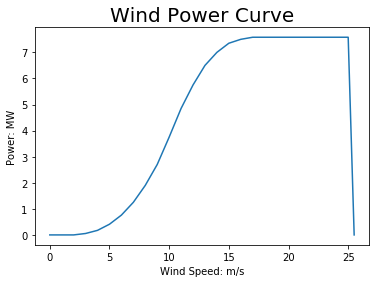

In [8]:
from windpowerlib.wind_turbine import WindTurbine

enerconE126 = {
    'turbine_name': 'ENERCON E 126 7500',  # turbine name as in register
    'hub_height': 135,  # in m
    'rotor_diameter': 127  # in m
    }

e126 = WindTurbine(**enerconE126)
f, ax = plt.subplots()
ax.plot(e126.power_curve.wind_speed,e126.power_curve.values[:,1]/1e6)
ax.set_title(f'Wind Power Curve', fontsize=20)
ax.set_xlabel('Wind Speed: m/s')
ax.set_ylabel('Power: MW')

Since the power curve is very non-linear, we cannot use linear regression yet. Instead we could use a general model that fits a curve.

### PyGAM: (General Additive Model)

PyGAM fits a series of splines, which can match many non-linear curves. In our case, the wind power curve has 4 regimes, which can each be fit with the splines.

<img src=./pygam_basis.png height="600" width="600">

#### Try adding power or wind speeds. Did not work with the model I went with.

In [11]:
import numpy as np
wp_pos = pd.DataFrame(np.interp(x=features_ws, xp=e126.power_curve.wind_speed.values,fp=e126.power_curve.values[:,1]), index=features_ws.index)
wp_neg = pd.DataFrame(np.interp(x=features_ws, xp=np.flip(-1 * e126.power_curve.wind_speed.values),fp=e126.power_curve.values[:,1]), index=features_ws.index)
features_wp = np.maximum(wp_pos, wp_neg)

features_both = pd.concat([features_ws, features_wp], axis=1)

### Split up our data to hide 3 months from the model

In [13]:
split_point = int(len(features_ws) * 0.75) # take 75%

X = features_ws

DDs_train, DDs_test = DDs[:split_point], DDs[split_point:]
WNDs_train, WNDs_test = WNDs[:split_point], WNDs[split_point:]
X_train, X_test = X[:split_point], X[split_point:]
y_train_0, y_test_0 = PROD.iloc[:split_point,0], PROD.iloc[split_point:,0]
y_train_1, y_test_1 = PROD.iloc[:split_point,1], PROD.iloc[split_point:,1]

print (f"Train data runs from: {X_train.index[0]} to {X_train.index[-1]}")
print (f"Test data runs from: {X_test.index[0]} to {X_test.index[-1]}")

Train data runs from: 2016-01-01 00:00:00 to 2016-10-01 12:00:00
Test data runs from: 2016-10-01 13:00:00 to 2016-12-31 23:00:00


### Setup our model:

Started with LinearGAM, where it allows for symmetric normal distributed error
Would also consider the GammaGAM

In [14]:
from pygam import LinearGAM, GammaGAM, s, f

# gam = LinearGAM(constraints='monotonic_inc')
gam_market_0 = LinearGAM(n_splines=10, lam=5)
gam_market_1 = LinearGAM(n_splines=10, lam=5)

# gam = GammaGAM()

In [15]:
# gam.gridsearch(X_train.values, y_train.values)
gam_market_0.fit(X_train, y_train_0)
gam_market_1.fit(X_train, y_train_1)

gam_market_0.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     99.2417
Link Function:                     IdentityLink Log Likelihood:                                -74885.2516
Number of Samples:                         6588 AIC:                                           149970.9867
                                                AICc:                                          149974.1157
                                                GCV:                                            35433.6172
                                                Scale:                                          34474.1327
                                                Pseudo R-Squared:                                   0.9575
Feature Function                  Lam

/home/willst/miniconda2/envs/pynio/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """


Scaled MAE: train 0.12691486340536648; test 0.19079170766496942; last month 0.23381569027721918
Scaled MAE: train 0.1758811594204023; test 0.25499377419612523; last month 0.2917063356803887


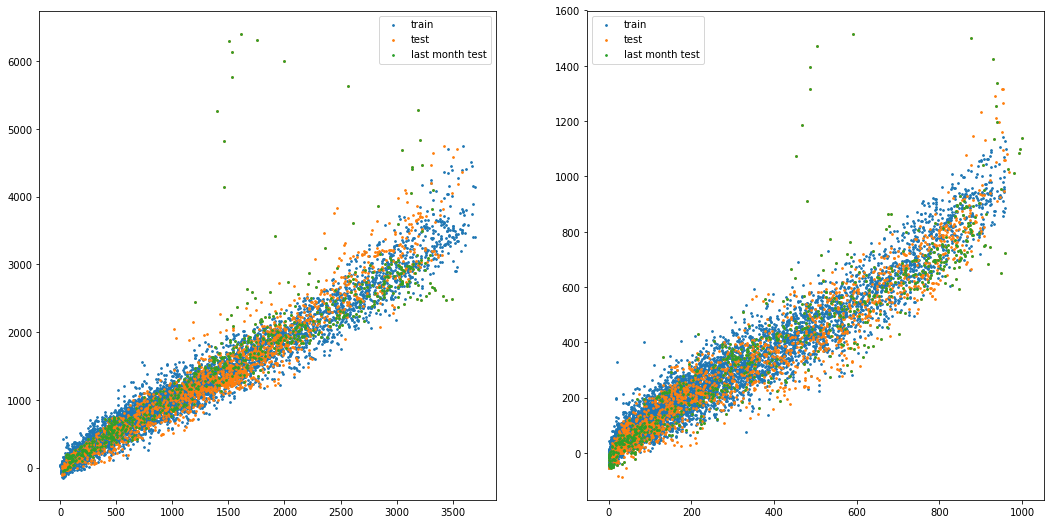

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,9))

def scatter_plots(model, y_tr, y_tst, ax):
    mth = 4 * 7 * 24
    ax.scatter(y_tr, model.predict(X_train), s=3)
    ax.scatter(y_tst, model.predict(X_test), s=3)
    ax.scatter(y_tst[-mth:], model.predict(X_test[-mth:]), s=3)
    ax.legend(["train", "test","last month test"])
    
    avg = y_tr.mean()
    
    err_train = mean_absolute_error(model.predict(X_train),y_tr) / avg
    err_test = mean_absolute_error(model.predict(X_test),y_tst) / avg
    err_last_test = mean_absolute_error(model.predict(X_test[-mth:]),y_tst[-mth:]) / avg

    print(f'Scaled MAE: train {err_train}; test {err_test}; last month {err_last_test}')    

scatter_plots(gam_market_0, y_train_0, y_test_0, ax0)
scatter_plots(gam_market_1, y_train_1, y_test_1, ax1)

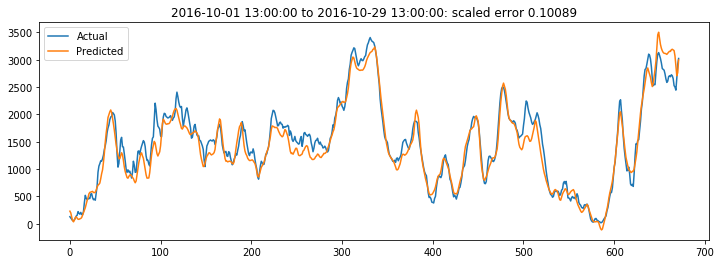

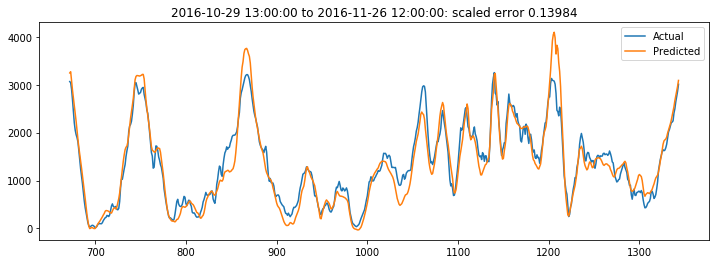

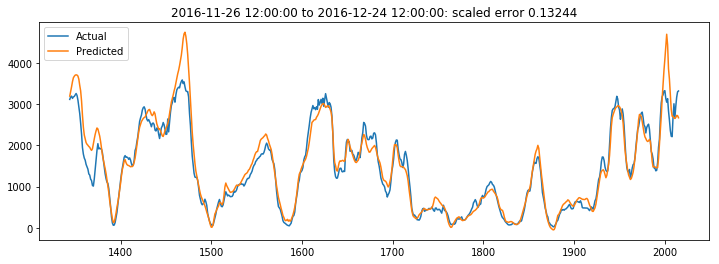

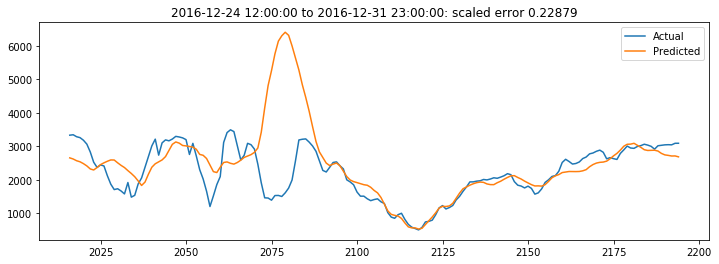

In [17]:
def time_plots(gam, y_test):

    mth = 24 * 7 * 4
    s = 0
    e = mth
    while s < len(y_test):
        f, ax = plt.subplots(figsize=(12,4))
        ax.plot(range(s,e),y_test[s:e],range(s,e),gam.predict(X_test)[s:e])
        err_test = mean_absolute_error(y_test[s:e],gam.predict(X_test)[s:e]) / np.mean(y_test[s:e])
        ax.set_title(f'{y_test.index[s]} to {y_test.index[e]}: scaled error {round(err_test,5)}')
        ax.legend(["Actual","Predicted"])

        s += mth
        e = min(e + mth, len(y_test) - 1)

time_plots(gam_market_0, y_test_0)

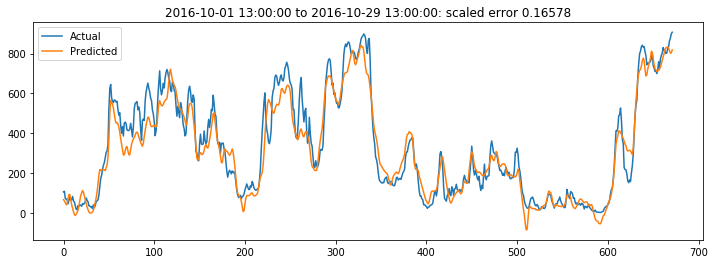

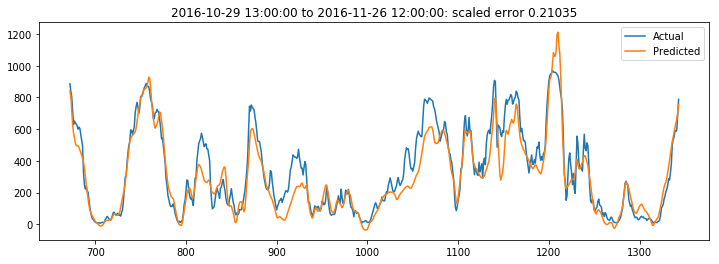

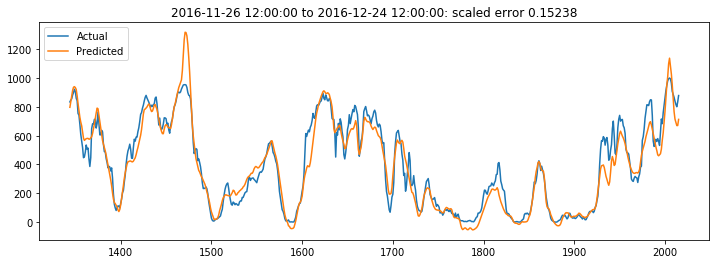

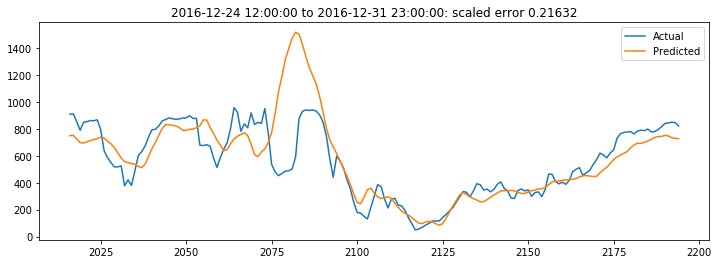

In [18]:
time_plots(gam_market_1, y_test_1)

## Conclusion

To me, this is a very good initial fit for the data and for good time periods the MAE (Mean Absolute Error) is a little over 10% for market 0, although around 18% for market 1. There are several places where choices were made and we could possibly improve the model further, such as how many directions we projected the wind speed. However, I would recommend looking into the time periods of poor fit and identify if it is due to the model, or need more data.


### Poor performance around index 2075 (Dec 27th)?

Beg: 2016-12-26 00:00:00; End: 2016-12-28 00:00:00
Max Train Wind Speed = 28.6
Max Test Wind Speed = 28.6
Count Train Wind Speed > 25.5 = 2
Count Test Wind Speed > 25.5 = 14


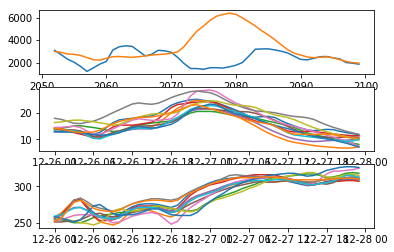

In [19]:
s = 2052
e = 2100
f, axs = plt.subplots(3,1)

axs[0].plot(range(s,e),y_test_0[s:e],range(s,e),gam_market_0.predict(X_test)[s:e])
axs[1].plot(WNDs_test[s:e])
axs[2].plot(DDs_test[s:e])
print(f'Beg: {WNDs_test.index[s]}; End: {WNDs_test.index[e]}')

print(f'Max Train Wind Speed = {WNDs.max().max()}')
print(f'Max Test Wind Speed = {WNDs_test[s:e].max().max()}')

print(f'Count Train Wind Speed > 25.5 = {np.sum(WNDs_train > 25.5).sum()}')
print(f'Count Test Wind Speed > 25.5 = {np.sum(WNDs_test > 25.5).sum()}')

## Discussion

Directly, the prediction (orange) makes sense with the input data where there is a peak in wind speed on the 27th. Not an issue of the model fitting the data poorly. Possible other causes. At the bottom will look into GFS.

3 hypothesis
1. Simplest is that went of 25m/s and turbines need to be shut off for safety. Confirmed comparing the counts of high speeds in the test and train set. Only 2 data points in the training set.
2. Icing conditions: since it is high winds in winter, possible ice storm which would requrie shutting down the wind turbines, so not just high winds, but also temperature.
3. Cutailment: looking at the timeseries graph, the predictions at peaks (4000,5000) is consistently overshooting the actual production.

### Most likely explanation: high winds over 25.5 m/s

If so, why can't the GAM model measure that. We will look below into an intuitive explanation of the GAM model.

We can plot the partial dependence, which is the weighed contribution from each input that gets added together. i.e. the total is the sum of all the charts though remember that the x-value (wind speed) depends on the angle.

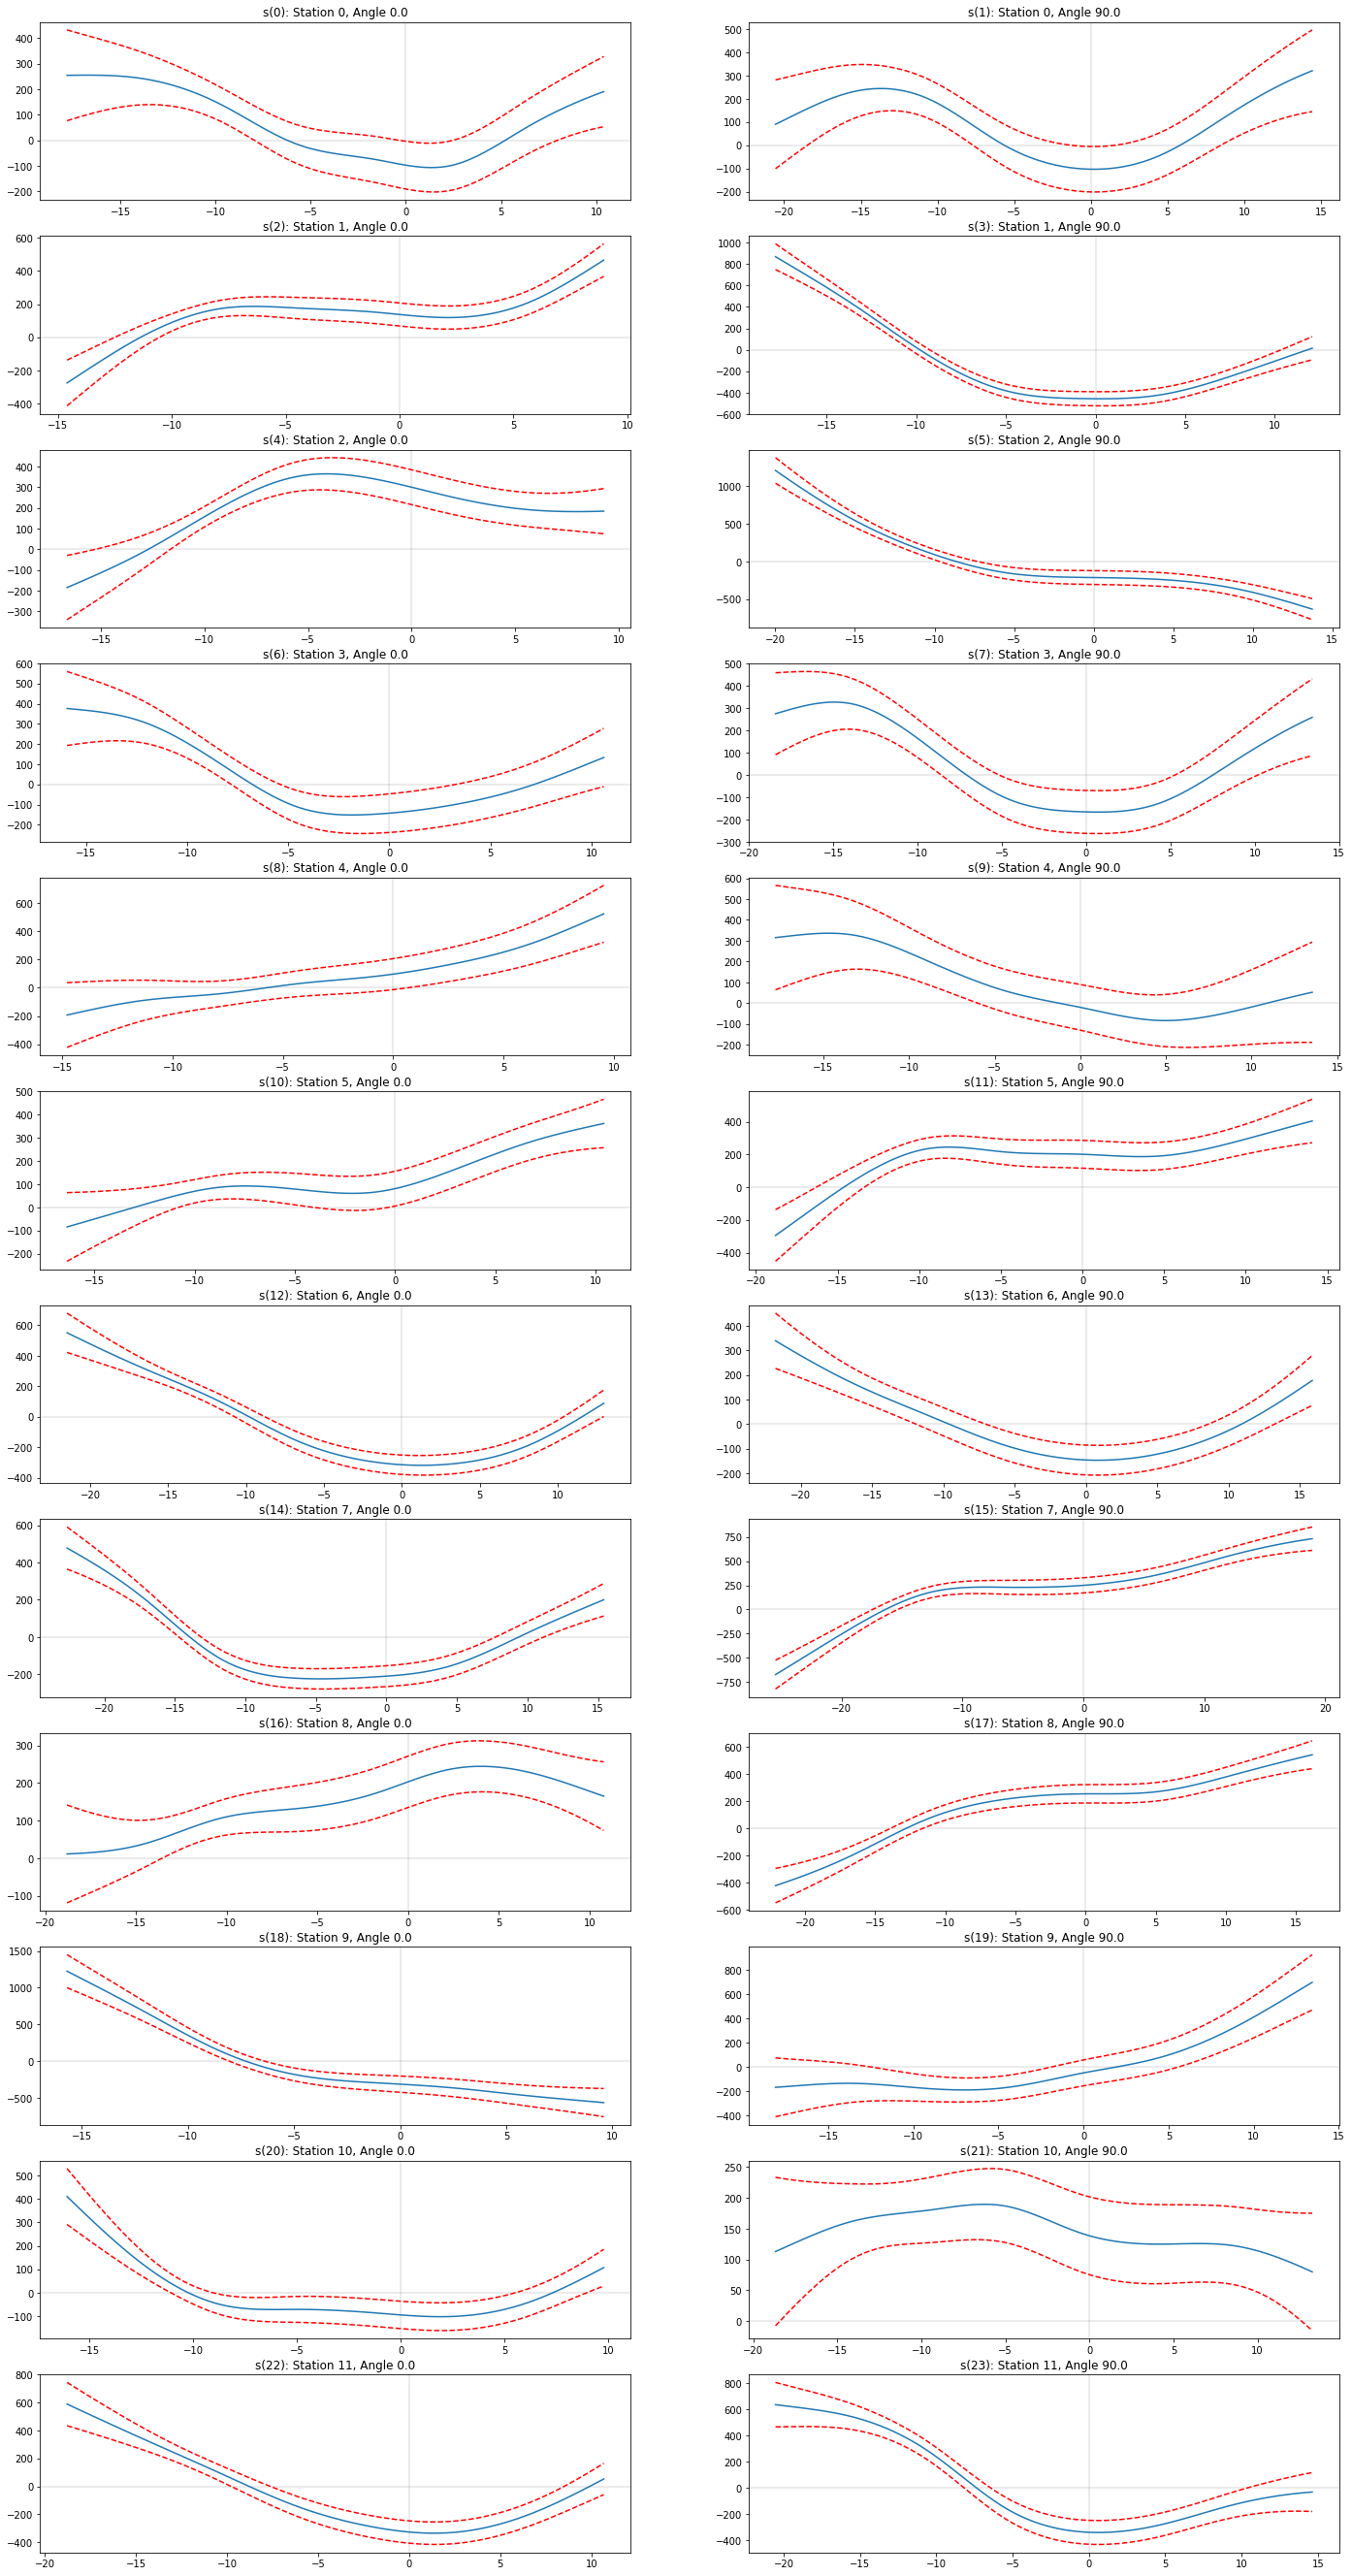

In [20]:
def partial_dependence_plots(gam):
    i = -1

    f, axs = plt.subplots(12, len(angles), figsize=(24,4*12))

    for s in range(12):
        for a in range(len(angles)):
            i += 1
            term = gam.terms[i]
            if term.isintercept:
                continue

            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

            ax = axs[s,a]
            ax.axhline(y=0, color='k', alpha=0.1)
            ax.axvline(x=0, color='k', alpha=0.1)

            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
            ax.set_title(f"{repr(term)}: Station {s}, Angle {float(angles[a])}")

partial_dependence_plots(gam_market_0)

## Ideas for next things to try

- The GAM model works well for smooth inputs and outputs. Not for the discontinuous drop-off in producation at 25.5 m/s. We could add extra categorical features, to help with that.

- I have worked with Hidden Markov Models in the past for energy disaggreagation where there was a change of 'state', not directly applicable here, but brought up that right now this model has no concept of time evolution. Without knowing the locations of the stations, we may still get an idea of where they are by looking at time-delayed correlation between the stations. The peak corelation would be a good indicator of the average time delay of a weather system. This is primarily helpful for very short term forecasts, where we have the current data from one station and use the time-delay to predict the immenent production at another station.

## Asside: Weather demo

Use the GFS to validate the wind data for Dec 27th and check a little into if the drop in production could be atributable to icing.

### Use xarray to easily read in GFS data


In [21]:
files = [f"gfsanl_3_201612{day}_0000_000.grb" for day in [26,27,28]]

gfs_data = xr.open_mfdataset(files, engine="pynio", concat_dim="time")

wind_spd = xr.ufuncs.hypot(gfs_data.U_GRD_3_HTGL, gfs_data.V_GRD_3_HTGL).sel(lv_HTGL6=80)

#### Check the values to see how xarray works and see if the data loaded properly

In [22]:
wind_spd

<xarray.DataArray (time: 3, lat_3: 181, lon_3: 360)>
dask.array<shape=(3, 181, 360), dtype=float32, chunksize=(1, 181, 360)>
Coordinates:
    lv_HTGL6  int32 80
  * lat_3     (lat_3) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon_3     (lon_3) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: time

#### GFS is a global dataset, so focus only on the data near Denmark

In [23]:
def filter_denmark(ds, degrees=4):
    ds = ds.where((np.abs(ds.lat_3 - 56.26) < degrees)).dropna(dim='lat_3') #looked up center and rough size of Denmark
    ds = ds.where((np.abs(ds.lon_3 - 9.50) < degrees)).dropna(dim='lon_3')
    return ds
den_wind_spd = filter_denmark(wind_spd)

### Plot the wind speeds from the 26th, 27th, 28th and see if it agrees with the other data

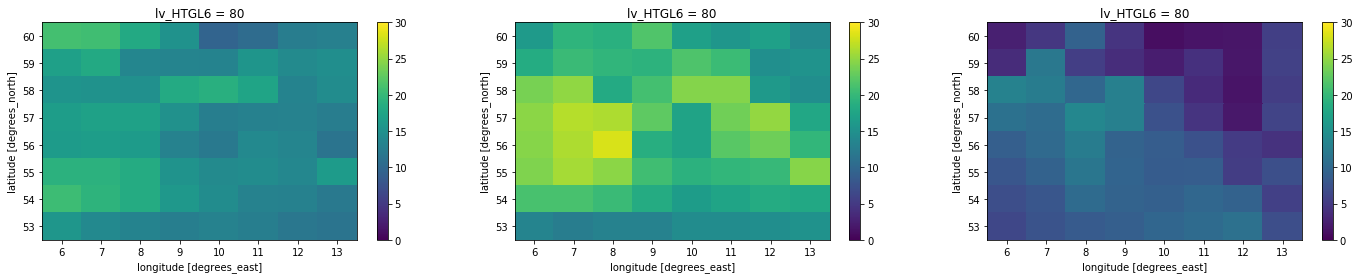

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(24,4))
for t in [0, 1, 2]:
    den_wind_spd.isel(time=t).plot(ax=axes[t], vmin=0, vmax=30)

### Plot the temperature as well; see if less than 0 Celsius for icing

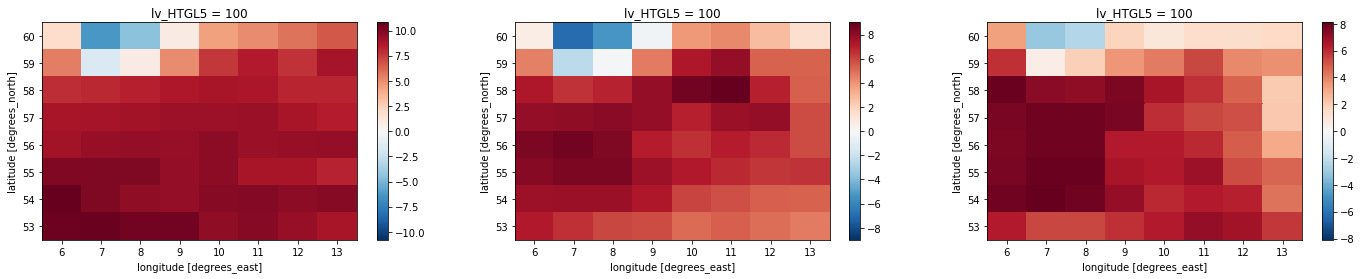

In [25]:
den_tmp = filter_denmark(gfs_data.TMP_3_HTGL.sel(lv_HTGL5=100)) - 273,15
den_tmp = den_tmp[0]

fig, axes = plt.subplots(ncols=3, figsize=(24,4))
for t in [0, 1, 2]:
    den_tmp.isel(time=t).plot(ax=axes[t])

## Conclusion

The GFS data agrees with the station data. If the discrepency is not due to wind speed > 25 stopping operation, then I would look next at non-weather datasets to figure out why.